In [ ]:
import logging
from typing import Callable, Literal, Optional, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize

from bwlogger import StyleAdapter
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional, Union, Any

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from aamalha.utils.performance import Performance
from bwbbgdl import GoGet
from bwlogger import StyleAdapter, basic_setup
from bwutils import TODAY, Date

from portfolio.construction import calculate_weights

from utils import get_available_trackers, load_trackers, correlation_to_distance
from plot import plot_results, scatter_plot

In [ ]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados")
INVERSE_QUOTED = (
    "JPY",
    "HKD",
    "PHP",
    "CHF",
    "CZK",
    "CAD",
    "CLP",
    "DKK",
    "NOK",
    "SEK",
    "RUB",
    "BRL",
    "MXN",
    "HUF",
    "PLN",
    "TRY",
    "ILS",
    "INR",
    "TWD",
    "KRW",
    "IDR",
    "CNH",
    "CNY",
    "SGD",
    "ZAR",
    "THB",
    "COP",
    "MYR",
    "HKD",
)

# Load Data

### Bloomberg Data

In [ ]:
path = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\Projeto Asset Allocation.xlsx"
df_base = pd.read_excel(path, index_col=0, skiprows=1, sheet_name="base_values")
df_base

### Auxiliar Table

In [ ]:
df_base_aux = pd.read_excel(path, index_col=0, usecols="A:F", sheet_name="aux")
df_base_aux

### Trackers

In [ ]:
ONSHORE_BENHCMARK = "BZACCETP Index"
OFFSHORE_BENHCMARK = "G0O1 Index"

list_trackers = []
for ticker in df_base_aux[df_base_aux["include"]].index:
    alias = df_base_aux.loc[ticker, "alias"]
    curncy = df_base_aux.loc[ticker, "currency"]
    excess_index = df_base_aux.loc[ticker, "excess_index"]
    s_total_return = df_base[ticker].copy().dropna()

    if curncy == "BRL":
        s_benchmark_return = df_base[ONSHORE_BENHCMARK]
    else: 
        s_benchmark_return = df_base[OFFSHORE_BENHCMARK]
        if curncy != "USD":
            s_total_return_local_ccy = s_total_return
            curncy = "EUR"
            ccy = df_base[f"USD{curncy} Curncy"].copy()
            if curncy in INVERSE_QUOTED:
                ccy = 1 / ccy
            s_total_return_usd = (s_total_return_local_ccy.diff(1) * ccy).dropna()
            s_total_return_usd = s_total_return_usd.reindex(s_total_return_local_ccy.index)
            s_total_return_usd.iloc[0] = (
                s_total_return_local_ccy.iloc[0] * ccy[s_total_return_usd.index[0]]
            )
            s_total_return_usd = s_total_return_usd.cumsum()
            s_total_return = s_total_return_usd.copy()

    if excess_index:
        s_excess_return = s_benchmark_return*0 + 1
    s_excess_return = (s_total_return / s_benchmark_return).dropna()
    s_excess_return.name = alias
    s_excess_return = s_excess_return / s_excess_return.iloc[0] * 100
    list_trackers.append(s_excess_return)

df_trackers = pd.concat(list_trackers, axis=1)

df_trackers.to_excel(OUTPUT_FOLDER.joinpath("trackers_excess_returns.xlsx"))
df_trackers.plot()

## Analysis

### Performance Trackers

In [ ]:
perf_trackers = Performance(df_trackers)
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.to_excel(OUTPUT_FOLDER.joinpath("performance_trackers.xlsx"))

### Correlation

In [ ]:
df_corr = np.log(df_trackers).diff(1).corr().copy()
df_corr.to_excel(OUTPUT_FOLDER.joinpath("full_sample_correlation.xlsx"))

### Dendogram

In [ ]:
linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="right",
    labels=df_corr.columns,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Assets")
plt.xlabel("Distance")
plt.savefig(OUTPUT_FOLDER.joinpath("dendrogram.svg"))
plt.show()

## Portfolio Construction

### Scatter Plot (vs IBOV)

C:\Users\pcampos\AppData\Local\Temp\ipykernel_20980\2691961990.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days:])


<Axes: xlabel='Dates'>

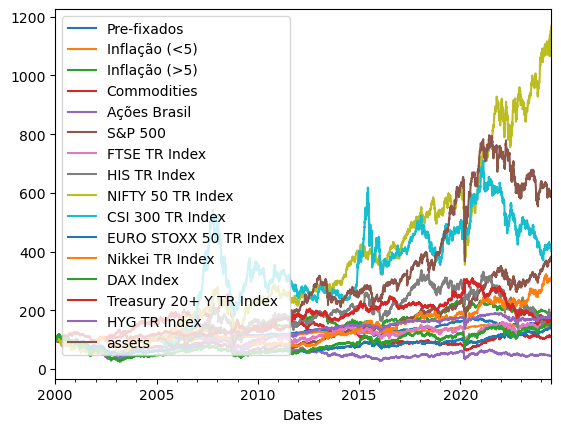

In [89]:
def backtest(
    tracker_df: pd.DataFrame,
    vol_target: float = 0.2,
    method_weights: Literal["hrp", "minvar", "ivp", "erc"] = "ivp",
) -> pd.DataFrame:
    vol_equity = 0.25
    vol_nonequity = 1/12

    STARTING_DATA_POINTS = 252 * 3
    STARTING_DATA_POINTS = 1305
    return_days = 21
    min_data_points = 252
    # min_data_points = 100

    backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days:])
    backtest.iloc[0] = 100.0

    starting_trackers = get_available_trackers(
        tracker_df.iloc[: STARTING_DATA_POINTS + return_days],
        STARTING_DATA_POINTS,
    )
    cov = (
        np.log(tracker_df)[starting_trackers].diff(return_days).cov()
        * 252
        / return_days
    )
    # print(starting_trackers)
    w = calculate_weights(
        np.log(tracker_df[starting_trackers]).diff(1), method=method_weights
    )
    # print(w.to_string())
    adj_factor = vol_target / np.sqrt(w @ cov @ w)
    w = adj_factor * w
    q = backtest.iloc[0] * w / tracker_df.iloc[0]

    for t, tm1 in zip(backtest.index[1:], backtest.index[:-1]):
        pnl = ((tracker_df.loc[t] - tracker_df.loc[tm1]) * q).sum()
        backtest[t] = backtest[tm1] + pnl
        if t.month != tm1.month:
            # print("Rebalance %s" % t.strftime("%m/%d/%Y"))
            available_trackers = get_available_trackers(
                tracker_df.loc[:t], min_data_points + return_days
            )
            # print("Available Trackers %s" % available_trackers)
            cov = (
                np.log(tracker_df.loc[:t][available_trackers]).diff(return_days).cov()
                * 252
                / return_days
            )
            w = calculate_weights(
                np.log(tracker_df.loc[:t][available_trackers]).diff(1),
                method=method_weights,
            )
            # print(w.to_string())
            adj_factor = vol_target / np.sqrt(w @ cov @ w)
            w = adj_factor * w
            q = backtest[tm1] * w / tracker_df.loc[tm1]

    df_backtest = pd.concat(
        [tracker_df, backtest.to_frame("assets")],
        axis=1,
        join="outer",
        sort=True,
    )
    return df_backtest


df_backtest = backtest(df_trackers, method_weights="ivp")
s_portfolio = np.log(df_backtest["assets"].copy()).diff(1).dropna()
s_ibov = np.log(df_backtest["Ações Brasil"].copy()).diff(1).dropna()


df_backtest.plot()

In [90]:
df_backtest.assets.dropna()

Dates
2005-02-01    100.000000
2005-02-02     99.748618
2005-02-03     99.552877
2005-02-04    100.069849
2005-02-07     99.455178
                 ...    
2024-06-20    592.847785
2024-06-21    594.336411
2024-06-24    597.971331
2024-06-25    597.506788
2024-06-26    593.302791
Freq: B, Name: assets, Length: 5062, dtype: float64

In [ ]:
scatter_plot(
    x_values=s_ibov,
    y_values=s_portfolio,
    yaxis_title="Portfolio Returns",
    xaxis_title="IBOV Returns",
    plot_title="Scatter Plot of Portfolio Returns vs. IBOV Returns",
    fit_type="linear",
    output_path=OUTPUT_FOLDER.joinpath("scatter_plot_portvolio_vs_ibov.svg"),
)

In [ ]:
df_weights = pd.concat(
    [
        calculate_weights(np.log(df_trackers).diff(5), method, long_only=True)
        for method in ["hrp", "minvar", "ivp", "erc"]
    ],
    axis=1,
)

In [ ]:
df_weights.T.plot(kind="bar", stacked=True)

plt.ylabel("Weight")
plt.title("Stacked Bar Chart Summing to 100%")
plt.show()